# Denver 2016 B-cycle Trip Data Exploration

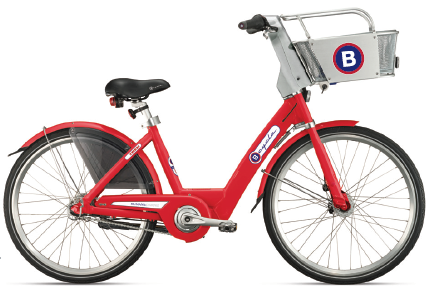

In [ ]:
from IPython.display import Image
image = Image('data/DenverBike.png')
image
# Source: http://denver.bcycle.com/docs/librariesprovider34/default-document-library/dbs_annualreport_2016_05.pdf

## 1. Introduction

[Denver B-cycle](https://denver.bcycle.com/) is a non-profit public bike sharing organization operating an automated bike sharing system called Denver B-cycle. Its mission is to "serve as a catalyst to fundamentally transform public thinking and behavior by operating a bike sharing system in Denver to enhance mobility while promoting all aspects of sustainability: quality of life, equity, the environment, economic development, and public health"  its purpose, its organization and discuss its relevance to this exploration.


Denver B-cycle posts its trips data set on its website as soon as its annual report is released. Trips data is available going back to 2011. The 2016 annual report and its associated dataset for this report were obtained from (https://www.denverbcycle.com/company). The original plan was to use the 2015 dataset to continue the effort by Tyler Byler who published a report [Exploring 2014 Denver B-cycle Ridership](https://github.com/tybyers). However, the 2016 data became available at the end of February 2017, so gears had to be rapidly shifted to use this data instead. To this end, the reporting style will follow Tyler's study to provide seamless continuity and good reference on trends and analyses.

## 2. The Datasets

The dataset is in an Excel .xlsx format and is a 27.2MB file. The Kiosk Information file is only 15.6KB in size. Because GitHub does not allow any file larger than 25MB, it was necessary to load it from the website at (http://denver.bcycle.com/docs/librariesprovider34/default-document-library/2016denverbcycletripdata_public.xlsx?sfvrsn=2) and compress it so that it could be uploaded to the GitHub repository.

In [ ]:
# import necessary libraries and modules
import pandas as pd
import numpy as np
from numpy import datetime64
import csv
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

In [ ]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [ ]:
# read converted csv compressed file from Excel xlsx. Bike_Number has mixed data types,
# so it needs to be declared as an object
dF = pd.read_csv("data/2016_Denver_Bike_Trip_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [ ]:
# main dataframe has 419611 rows of data
dF.shape

### Trips dataframe data structure

Trips dataframe has 11 columns, two int64 and 9 object data types. The column names were updated in 
Denver_2016_Excel_to_CSV_File_Conversion.ipynb
The original columns in the Excel file were ["User's Program", "User ID", "Membership Type", "Bike", "Checkout Date",
"Checkout Time", "Checkout Kiosk", "Return Date", "Return Time", "Return Kiosk", "Duration (Minutes)"]

In [ ]:
dF.info()

In [ ]:
dF.head(3)

### Convert Checkout_Date and Return_Date columns to DateTime64 datatype

In [ ]:
dF['Checkout_Date'] = dF[['Checkout_Date']].astype('datetime64[ns]')
dF['Return_Date'] = dF[['Return_Date']].astype('datetime64[ns]')

In [ ]:
# Sort checkout dates in ascending order
dF.sort_values(['Checkout_Date'], inplace=True)

In [ ]:
dF.head(3)

## 3. Data Wrangling

### Filtering the main dataframe to obtain actual miles ridden

Denver B-cycle prides itself on the number of trips and miles ridden by its members or customers. In order to be as accurate
as possibe, the dataset needs to be filtered accordingly. To start off, rows with a trip duration of one minute account for
**10,115** of the 419,611 rows **(2.4%)** in the dataset. Incidentally, these rows also show the Checkout Kiosk and the Return Kiosk to be the same. It is possible that riders were not pleased with their bike selection and returned them in a few minutes after renting them.

In [ ]:
# Check to see number of trips made with 15 minutes or less
dX = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Duration"] < 16)]

In [ ]:
# plot the results
ax = dX.groupby('Trip_Duration').size().plot(kind='bar', figsize=(14,5), color='blue', width=1.0, xlim=(0,16))
plt.title('Trip Duration When Return And Checkout Kiosks Are The Same', fontsize = 20)
plt.xlabel('Trip Duration (Minutes)', fontsize = 14)
plt.ylabel('Number of Trips', fontsize = 14)
plt.show()

In [ ]:
# remove rows that have a trip duration of 1 minute
dF.drop(dF[dF['Trip_Duration'] == 1].index, inplace = True)

### Estimated Trips = 409,496

In [ ]:
# main dataframe has 409496 rows to work with, a reduction of 10,115 data rows
dF.shape

### Load Kiosk public data, modify column names

The Kiosk Excel file has names, addresses and geopgraphical coordinates of the 89 Checkout and Return Kiosks. This important information was not available prior to 2016 and had to be created manually. This file needs to be prepared for use with additional code to retrieve distances between Kiosks using the Google Distance Matrix API obtained via its site: (https://developers.google.com/maps/documentation/javascript/examples/distance-matrix). This service requires the user to obtain a key that is used to retrieve up to a maximum of 2500 calls per day.

In [ ]:
# read in Kiosk information from the Denver Bike Share public data site
dC= pd.read_excel('https://denver.bcycle.com/docs/librariesprovider34/default-document-library/october2016_kioskinfo.xlsx')

In [ ]:
dC.info()

In [ ]:
dC.shape

In [ ]:
# use descriptive column names
new_colnames = ['Checkout_Kiosk', 'Checkout_Kiosk_Address', 'Checkout_Kiosk_Longitude', 
                'Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Total_Docks']
dC.columns = new_colnames

In [ ]:
dC.info()

In [ ]:
# don't need address and docks for retrieving distances from Google Distance API
dC.drop(['Checkout_Kiosk_Address', 'Checkout_Kiosk_Total_Docks'], axis = 1, inplace=True)

In [ ]:
dC.info()

In [ ]:
# make a copy for Return Kiosks
dR = dC.copy(deep=True)

In [ ]:
dR.info()

In [ ]:
# use descriptive column names
new_colnames = ['Return_Kiosk', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude']
dR.columns = new_colnames

In [ ]:
# add Return Kiosks details to Checkout Kiosks details
dCR = pd.concat([dC, dR], axis = 1)

### Save Kiosk data for use with Google Distance Matrix API

File is ready for use with additional python/pandas code (Denver_Bike_Share_Distance_Duration_Submit.py) to retrieve distances between Kiosks using the Google Distance Matrix API. The retrieved distances are saved in (Denver_Bike_Kiosks_Distances_Durations.csv).

In [ ]:
# save dataframe to csv file for use in getting distances from Googe Distance API
dCR.to_csv('data/Denver_Bike_Kiosks_Details.csv', index = False)

### Retrieve Kiosk distances and add Kiosks that have the same starting and ending trip information

File is ready for merging with the Trips dataframe in order to calculate the total miles ridden. But prior to this, 89 more data rows where the Checkout Kiosk and the Return Kiosk are the same have to added to the retrieved file that has distances retrieved from Google. These 89 rows will have the Trip_Distance column reporting zeros but there could be bikes rented from the Checkout Kiosk and returned to it which is considered valid data.

In [ ]:
# read in distance information retrieved from Google Distance API
dK = pd.read_csv('data/Denver_Bike_Kiosks_Distances_Durations.csv')

In [ ]:
# Drop columns that are not relevant for merging with the Trips dataframe
dK.drop(['Checkout_Kiosk_Latitude', 'Checkout_Kiosk_Longitude', 'Return_Kiosk_Latitude', 'Return_Kiosk_Longitude',
         'Distance_Checkout_Return', 'Duration_Checkout_Return', 'Distance_Return_Checkout',
         'Duration_Return_Checkout', 'Average_Duration'], axis = 1, inplace = True)

In [ ]:
dK.info()

In [ ]:
# read csv file for use in 
dCR = pd.read_csv('data/Denver_Bike_Kiosks_Details.csv')

In [ ]:
dCR.info()

In [ ]:
dD = dCR.where(dCR['Checkout_Kiosk'] == dCR['Return_Kiosk'])

In [ ]:
dD.info()

In [ ]:
dD.head(3)

In [ ]:
# Drop columns that are not relevant
dD.drop(['Checkout_Kiosk_Longitude', 'Checkout_Kiosk_Latitude', 'Return_Kiosk_Longitude', 'Return_Kiosk_Latitude'],
        axis = 1, inplace = True)

In [ ]:
# add Average_Distance column and fill with zeros
dD['Average_Distance'] = 0

In [ ]:
dD.head(3)

In [ ]:
# add these rows to the retrieved distances dataframe
dK = pd.concat([dK, dD], axis = 0)

In [ ]:
# A combination of 89 Checkout and Return Kiosks should give a value of 7921
dK.info()

In [ ]:
dF.info()

### Merge with Trips dataframe and remove invalid rows

In [ ]:
# merge distance information retrieved from Google Distance API with Trips dataframe
dF = pd.merge(dF, dK, how='left', left_on=['Checkout_Kiosk', 'Return_Kiosk'], right_on=['Checkout_Kiosk', 'Return_Kiosk'])

In [ ]:
# Trips dataframe now has 409539 rows, an increase of 43 rows (409539-409496), possibly due to invalid stations
# and the Average_Distance column shows only 402965 rows of valid data
dF.info()

In [ ]:
dF.head(3)

In [ ]:
# Check to confirm there are null values in the dataframe
dF.isnull().values.any()

In [ ]:
# locate the rows with null data 
nan_rows = dF[dF.isnull().T.any().T]

### Rows with invalid Kiosks = 6574

In [ ]:
# found 6574 rows!! - mostly from DBS LARIMER WAREHOUSE and 'Dead and Missing Bikes' Kiosks which are not in the Kiosk List!!
nan_rows.head(3)

In [ ]:
# remove these 6574 rows from the dataframe
dF = dF.drop(dF.index[nan_rows.index])

In [ ]:
# Main dataframe now has 402,965 rows to work with
dF.info()

In [ ]:
dF.rename(columns = {'Average_Distance' : 'Trip_Distance'}, inplace = True)

In [ ]:
dF.head(3)

In [ ]:
dF.info()

### Estimate Trip Distance for Kiosks that have the same starting and ending trip information

In [ ]:
# Valid data that needs to aggregated to total distance
# Checkout Kiosk == Return_Kiosk and Trip_Distance == 0
dD = dF[(dF["Checkout_Kiosk"] == dF["Return_Kiosk"]) & (dF["Trip_Distance"] == 0)]

In [ ]:
# valid data rows = 31349
dD.shape

In [ ]:
dD.head(3)

In [ ]:
dD['Trip_Duration'].sum()

In [ ]:
dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum()

In [ ]:
dF['Trip_Distance'].sum()

### Estimate average speed for use in Kiosks that have the same and ending trip infomation

In [ ]:
avSpeed =  (dF['Trip_Distance'].sum()) /(dF['Trip_Duration'].sum() - dD['Trip_Duration'].sum())

In [ ]:
avSpeed # miles/min

In [ ]:
dE = dD.copy(deep=True)

In [ ]:
# Multiply the trip duration by average speed to get distance
dE['Trip_Distance'] = dE['Trip_Duration'].map(lambda x: x*avSpeed)

In [ ]:
# drop columns that are not relevant to the merge with the Trips dataframe
dE.drop(dE.columns[[0,1,2,3,4,5,6,7,8,9,10]], axis=1, inplace=True)

In [ ]:
dE.info()

In [ ]:
# merge the 31453 rows into the 409539 rows of the main dataframe
dF = pd.merge(dF, dE, how = 'left', left_index=True, right_index= True)

In [ ]:
dF.info()

In [ ]:
dF.head(3)

In [ ]:
# convert the NaN values to numeric and fill them with zeros
dF[['Trip_Distance_y']] = dF[['Trip_Distance_y']].apply(pd.to_numeric)
dF['Trip_Distance_y'].fillna(0, inplace=True)

In [ ]:
# update the distance values in the main dataframe
dF['Trip_Distance'] = dF['Trip_Distance_x'] + dF['Trip_Distance_y']

In [ ]:
dF.drop(['Trip_Distance_x'], axis = 1, inplace=True)

In [ ]:
dF.drop(['Trip_Distance_y'], axis = 1, inplace=True)

In [ ]:
totalDistance = dF['Trip_Distance'].sum()

### Distance Traveled = 670,802 miles

Denver Bike Sharing 2016 Annual Report records estimated miles ridden = **755,409**. This report shows **670,802** miles ridden, a delta of **85,607** or **11%**.

In [ ]:
totalDistance

### Most Popular Checkout Kiosks

In [ ]:
# Most popular Checkout Kiosks
mostPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [ ]:
mostPopular.head(10)

In [ ]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Map of Checkout Kiosk Popularity

In [ ]:
from IPython.display import Image
image = Image('data/Checkouts_By_Checkout_Kiosk.jpg')
image

### Most Popular Return Kiosks

In [ ]:
# Most popular Return Kiosks
mostPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [ ]:
mostPopular.head(10)

In [ ]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Most Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

### Map of Return Kiosk Popularity

In [ ]:
image = Image('data/Returns_By_Return_Kiosks.jpg')
image

### Least Popular Checkout Kiosks

In [ ]:
# Least popular Checkout Kiosks
leastPopular = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False)

In [ ]:
leastPopular.tail(10)

In [ ]:
# plot the results
ax = dF.groupby('Checkout_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Checkout Kiosks")
plt.xlabel('Checkout Kiosk')
plt.ylabel('Number of Checkouts')
plt.show()

### Least Popular Return Kiosks

In [ ]:
# Least popular Return Kiosks
leastPopular = dF.groupby('Return_Kiosk').size().sort_values(ascending=False)

In [ ]:
leastPopular.tail(10)

In [ ]:
# plot the results
ax = dF.groupby('Return_Kiosk').size().sort_values(ascending=False).tail(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title("Least Popular Return Kiosks")
plt.xlabel('Return Kiosk')
plt.ylabel('Number of Returns')
plt.show()

### Checkouts Per Membership Type

In [ ]:
# Checkouts by Membership Type
membership = dF.groupby('Membership_Type').size().sort_values(ascending=False)

In [ ]:
# there are 56250 rows with Membership = Not Applicable, a significant 14%
membership.head(10)

In [ ]:
# plot the results
ax = dF.groupby('Membership_Type').size().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Membership Type Breakdown (Top Ten)', fontsize = 20)
plt.xlabel('Membership Type)', fontsize = 14)
plt.ylabel('Number of Members', fontsize = 14)
plt.show()

In [ ]:
dF.head(3)

In [ ]:
dF.rename(columns = {'Checkout_Time' : 'Checkout_Hour'}, inplace = True)

### Convert Checkout Time to Checkout_Hour

In [ ]:
dF['Checkout_Hour'] = dF['Checkout_Hour'].map(lambda x: x[:2]).astype(int)

In [ ]:
dF.head(3)

### Ridership by Calendar and Clock Variables

In [ ]:
# plot the results
ax = dF.groupby('Checkout_Hour').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,25))
plt.title('Total Number of Checkouts by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
dH = dF.groupby(['Checkout_Hour']).mean()

In [ ]:
dH.info()

In [ ]:
dH.drop(['User_ID', 'Trip_Duration'], axis=1, inplace=True)

In [ ]:
ax = dH.plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,24))
plt.title('Average Distance Ridden by Hour of the Day', fontsize = 20)
plt.xlabel('Checkout Hour of Day', fontsize = 14)
plt.ylabel('Average Distance Ridden (Miles)', fontsize = 14)
ax.legend().set_visible(False)
plt.show()

### Ridership by Hour and Weekday

#### Create Checkout_Weekday Column in Weather dataframe

In [ ]:
# Create a new column called Checkout_WeekDay
dF['Checkout_WeekDay'] = pd.DatetimeIndex(dF['Checkout_Date']).weekday

In [ ]:
dMon = dF.where(dF['Checkout_WeekDay'] == 0)
dTue = dF.where(dF['Checkout_WeekDay'] == 1)
dWed = dF.where(dF['Checkout_WeekDay'] == 2)
dThu = dF.where(dF['Checkout_WeekDay'] == 3)
dFri = dF.where(dF['Checkout_WeekDay'] == 4)
dSat = dF.where(dF['Checkout_WeekDay'] == 5)
dSun = dF.where(dF['Checkout_WeekDay'] == 6)

In [ ]:
axMon = dMon.groupby('Checkout_Hour').size()
axTue = dTue.groupby('Checkout_Hour').size()
axWed = dWed.groupby('Checkout_Hour').size()
axThu = dThu.groupby('Checkout_Hour').size()
axFri = dFri.groupby('Checkout_Hour').size()
axSat = dSat.groupby('Checkout_Hour').size()
axSun = dSun.groupby('Checkout_Hour').size()

In [ ]:
# plot the results
plt.figure()
plt.figure(figsize=(13,10))
plt.suptitle('Total Number of Checkouts by Hour of the Day per Weekday', fontsize=16)

#plt.xlabel('xlabel', fontsize=10)
#plt.ylabel('ylabel', fontsize=10)
plt.subplot(4,3,1)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Monday', fontsize=12)
plt.plot(axMon,'b-')

plt.subplot(4,3,2)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Tuesday', fontsize=12)
plt.plot(axTue,'b-')

plt.subplot(4,3,3)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Wednesday', fontsize=12)
plt.plot(axWed,'b-')

plt.subplot(4,3,4)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Thursday', fontsize=12)
plt.plot(axThu,'b-')

plt.subplot(4,3,5)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)  
plt.title('Friday', fontsize=12)
plt.plot(axFri,'b-')

plt.subplot(4,3,6)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Saturday', fontsize=12)
plt.plot(axSat,'b-')

plt.subplot(4,3,7)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9) 
plt.title('Sunday', fontsize=12)
plt.plot(axSun,'b-')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig = plt.gca()

### Ridership by Month

#### Create Checkout_Month column in Trips dataframe

In [ ]:
# Create a new column called Checkout_Month
dF['Checkout_Month'] = pd.DatetimeIndex(dF['Checkout_Date']).month

In [ ]:
dM = dF.groupby(['Checkout_Month'])

In [ ]:
dM.size()

In [ ]:
# plot the results
ax = dF.groupby('Checkout_Month').size().plot(kind='bar', figsize=(13,6), 
                color='blue', width=0.7, xlim=(0,15))
plt.title('Total Number of Checkouts by Month', fontsize = 20)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Total Number of Checkouts', fontsize = 14)
plt.show()

## Merging with Weather

### Merge Daily Weather Data with Trips DataFrame

In [ ]:
dW = pd.read_csv("data/Denver_2016_Daily_Weather_Forecast.csv")

In [ ]:
dW.info()

In [ ]:
dW.head(3)

In [ ]:
dW.isnull().values.any()

In [ ]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [ ]:
dW.sort_values(['Date'], inplace=True)

In [ ]:
#dW.drop(['cloudCover', 'windSpeed', 'humidity'], axis = 1, inplace=True)

In [ ]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date'], right_on=['Date'])

In [ ]:
dF.shape

In [ ]:
dF.isnull().values.any()

In [ ]:
dF.drop(['Date'], axis = 1, inplace = True)

### Ridership by Day

Plot above shows temperature affects ridership. Daily temperatures in the 70s to 80s result in the highest ridership while temperatures 35F and below result in the lowest ridership. Also, ridership is high on weekends (Sunday, labeled as 6 and Saturday, labeled as 5) and during the months between May and June. Conversely, the winter months (December to February) have the lowest ridership unless the temperature is favorable on those days, which is typical of Colorado.

In [ ]:
ax = dF.groupby('temperatureMax').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Max Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('temperatureMin').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Min Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

In [ ]:
ax = dF.groupby('apparentTemperatureMax').size().plot(kind='line', figsize=(14,6), 
                color='blue', label='Max Apparent Temperature', fontsize=12, xlim=(-10,100))
ax = dF.groupby('apparentTemperatureMin').size().plot(kind='line', figsize=(14,6), 
                color='red', label='Min Apparent Temperature', fontsize=12, xlim=(-10,100))
plt.title('Total Number of Checkouts vs. Daily Apparent Temperature', fontsize = 20)
plt.xlabel('Apparent Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

In [ ]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(14,6), 
                color='blue', fontsize=12, xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,18))
plt.title('Total Number of Checkouts vs. Daily Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Daily Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(14,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Visibility', fontsize = 20)
plt.xlabel('Visibility', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
dHRD = dF.groupby(['Checkout_WeekDay', 'Checkout_Date', 'temperatureMax', 'temperatureMin'])['Checkout_WeekDay']

In [ ]:
dHRD.size().sort_values(ascending=False).head(10)

In [ ]:
dHRD.size().sort_values(ascending=False).tail(10)

In [ ]:
dF.drop(['apparentTemperatureMax', 'apparentTemperatureMin', 'temperatureMax', 'temperatureMin',
         'cloudCover', 'humidity', 'windSpeed', 'visibility'], axis = 1, inplace = True)

### Merge Hourly Weather with Trips DataFrame

In [ ]:
dW = pd.read_csv("data/Denver_2016_Hourly_Weather_Forecast.csv")

In [ ]:
dW.info()

In [ ]:
dW.head(3)

In [ ]:
dW.describe()

In [ ]:
dW.isnull().values.any()

In [ ]:
nan_rows = dW[dW.isnull().T.any().T]

In [ ]:
nan_rows

In [ ]:
dW = dW.drop(dW.index[nan_rows.index])

In [ ]:
dW.isnull().values.any()

#### Convert Date column in Weather dataframe

In [ ]:
dW['Date'] = pd.to_datetime(dW['Date'])

In [ ]:
dW.sort_values(['Date', 'Hour'], inplace=True)

In [ ]:
dW.head(3)

In [ ]:
dW.describe()

In [ ]:
dF = pd.merge(dF, dW, how='left', left_on=['Checkout_Date', 'Checkout_Hour'], right_on=['Date', 'Hour'])

In [ ]:
dF.shape

In [ ]:
dF.isnull().values.any()

In [ ]:
nan_rows = dF[dF.isnull().T.any().T]

In [ ]:
nan_rows.info()

In [ ]:
dF = dF.drop(dF.index[nan_rows.index])

In [ ]:
dF.isnull().values.any()

In [ ]:
dF.head()

In [ ]:
dF.drop(['Date'], axis = 1, inplace = True)
dF.drop(['Hour'], axis = 1, inplace = True)

### Checkouts vs. Hourly Temperature

In [ ]:
ax = dF.groupby('temperature').size().plot(kind='line', figsize=(13,6), 
                color='blue', label='Hourly Temperature', xlim=(0,100))
ax = dF.groupby('apparentTemperature').size().plot(kind='line', figsize=(13,6), 
                color='red', label='Hourly Apparent Temperature', xlim=(0,100))
plt.title('Total Number of Checkouts vs. Hourly Temperature', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.legend(loc=2, fontsize='large')
plt.show()

### Checkouts vs. Hourly Humidity

In [ ]:
ax = dF.groupby('humidity').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Hourly Humidity', fontsize = 20)
plt.xlabel('Humidity', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Cloud Cover

In [ ]:
ax = dF.groupby('cloudCover').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,1))
plt.title('Total Number of Checkouts vs. Hourly Cloud Cover', fontsize = 20)
plt.xlabel('Cloud Cover', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Wind Speed

Wind speed significantly impacts ridership. Speeds between 0 and 5 miles per hour are very favorable to renting bikes. Rideship radipdly diminshes at 10 or higher miles per hour.

In [ ]:
ax = dF.groupby('windSpeed').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,35))
plt.title('Total Number of Checkouts vs. Hourly Wind Speed', fontsize = 20)
plt.xlabel('Wind Speed (Miles per Hour)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

### Checkouts vs. Hourly Visibility

In [ ]:
ax = dF.groupby('visibility').size().plot(kind='line', figsize=(13,6), 
                color='blue', xlim=(0,12))
plt.title('Total Number of Checkouts vs. Hourly Visibility', fontsize = 20)
plt.xlabel('Visibility (Miles)', fontsize = 14)
plt.ylabel('Number of Checkouts', fontsize = 14)
plt.show()

In [ ]:
dF.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [ ]:
# save csv file in preparation for use in the Machine Learning phase
dF.to_csv("data/2016_Denver_Bike_Trip_ML_Data.gz", index=False, compression="gzip")